In [1]:
# Import packages
import numpy as np
from skimage.segmentation import slic, mark_boundaries
from skimage.transform import resize
from skimage.filters import gaussian
from PIL import Image
import matplotlib.pyplot as plt

# Import samplers
from samplers import RandomSampler, SingleFeatureSampler, ShapSampler
# Import explainers
from explainers import OriginalCIUAttributer, SHAPAttributer, RISEAttributer
# Import segmenters
from image_segmenters import GridSegmenter, WrapperSegmenter
# Import segmentation and perturbation utils
from image_segmenters import FadeMaskTransformer, perturbation_masks
# Import image perturbers
from image_perturbers import SingleColorPerturber, ReplaceImagePerturber, TransformPerturber
# Import image explanation visualizers
from image_visualizers import TopVisualizer, HeatmapVisualizer
# Import explanation evaluators
from evaluation import auc_sampler

# Set seed for reproducibility (due to random noise used later)
np.random.seed(0)

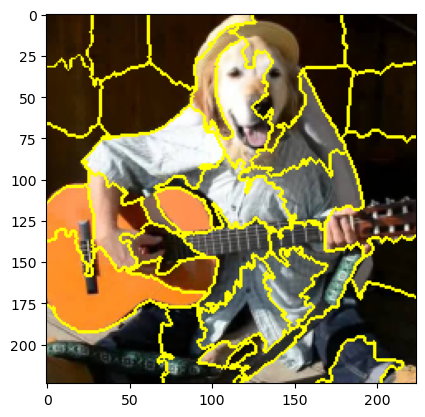

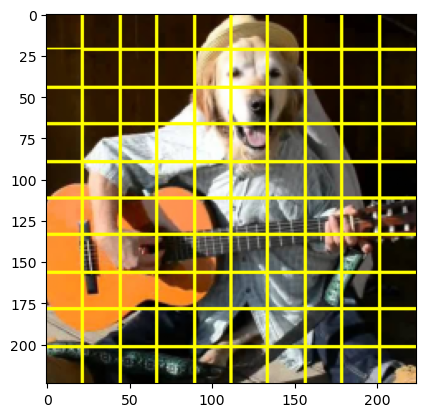

In [2]:
# Collecting the image and resizing to fit later model input
img = resize(np.array(Image.open('images/LabradorPlayingGuitar.jpg')), (224,224,3))

# Segmenting the image into a grid or with SLIC
grid_segments, grid_masks = GridSegmenter(10, 10, bilinear=False)(img)
slic_segments, slic_masks = WrapperSegmenter(slic, n_segments=50, compactness=10, start_label=0)(img)

# Counting the number of segments in each
nr_grid_segments = grid_masks.shape[0]
nr_slic_segments = slic_masks.shape[0]

# Fading the grid masks by blurring with a gaussian kernel to make the border less harsh
faded_grid_masks = FadeMaskTransformer(sigma=10)(grid_masks)

# Displaying the image and segmentations
plt.figure()
plt.imshow(mark_boundaries(img, slic_segments))
plt.figure()
plt.imshow(mark_boundaries(img, grid_segments))

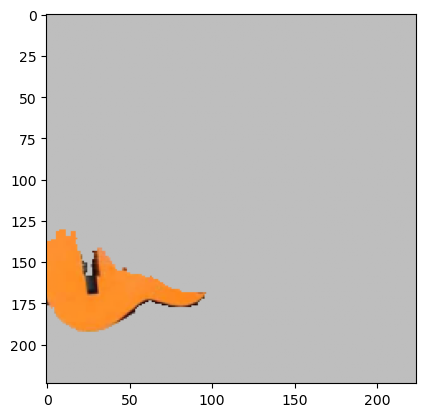

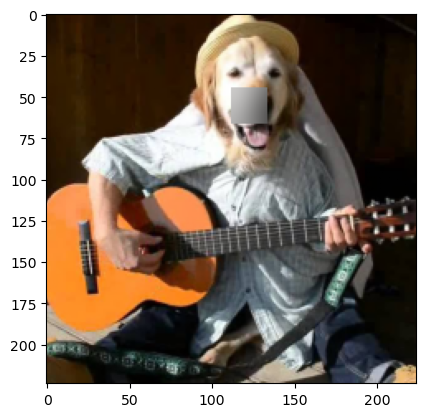

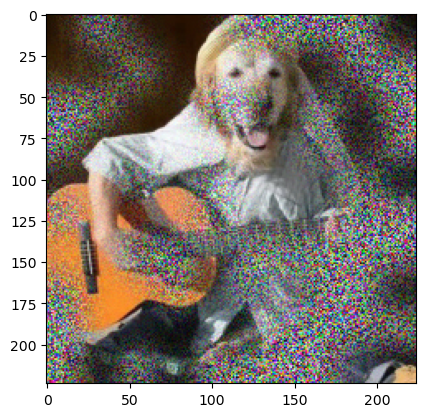

In [3]:
# Create the samples that indicate which segments to include and which to perturb
# In this case the standard samplers for each attribution method is used
shap_slic_samples = ShapSampler()(nr_slic_segments, sample_size=nr_slic_segments*2+2)
ciu_grid_samples  = SingleFeatureSampler(add_none=True)(nr_grid_segments)
rise_grid_samples = RandomSampler()(nr_grid_segments, sample_size=nr_grid_segments)

# Combines the samples with the segment masks to create masks for where to perturb the image
shap_perturbation_masks = perturbation_masks(slic_masks, shap_slic_samples)
ciu_perturbation_masks  = perturbation_masks(grid_masks, ciu_grid_samples)
rise_perturbation_masks = perturbation_masks(faded_grid_masks, rise_grid_samples)

# Creating perturbed versions of the image for each sample using the different perturbation masks
# Images are perturbed by replacing masked pixels with a static color, blurring, or replacing with noise
gray_perturbation = SingleColorPerturber(color=np.array((190,190,190))) #Create a reusable perturber so we can use it later to visualize
perturbed_shap_imgs, shap_samples = gray_perturbation(img, shap_perturbation_masks, shap_slic_samples)
blur_perturbation = TransformPerturber(gaussian, sigma=10) # Reusable perturber for visualization later
perturbed_ciu_imgs, ciu_samples   = blur_perturbation(img, ciu_perturbation_masks, ciu_grid_samples)
rand_img = np.random.rand(*img.shape) # Create a random noisy image to replace masked pixels with
perturbed_rise_imgs, rise_samples = ReplaceImagePerturber(rand_img)(img, rise_perturbation_masks, rise_grid_samples)

# Displaying some perturbed images
plt.figure()
plt.imshow(perturbed_shap_imgs[25])
plt.figure()
plt.imshow(perturbed_ciu_imgs[25])
plt.figure()
plt.imshow(perturbed_rise_imgs[25])

In [4]:
# Import Torchvision which will be used for inference
import torchvision
from torchvision.transforms import v2

# Import Torchvision utils
from torch_utils import TorchModelWrapper, ImageToTorch

# Collect an ImageNet pretrained AlexNet model to predict image classes
alexnet = torchvision.models.alexnet(weights='IMAGENET1K_V1')
alexnet.eval()

# Create a transform to prepare images for torchvisiona and AlexNet
transforms = v2.Compose([
    ImageToTorch(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.Resize((224,224))
])

# Use the TorchModelWrapper to transform images to torch for the model and back to numpy after
model = TorchModelWrapper(alexnet, transforms)

# Calculate the output values for each perturbed image
shap_y = model(perturbed_shap_imgs)
ciu_y  = model(perturbed_ciu_imgs)
rise_y = model(perturbed_rise_imgs)

In [5]:
# The ImageNet indexes for labrador and acoustic guitar
labrador = 208
guitar = 402

# Extract the predictions for labrador and guitar
shap_labrador = shap_y[:, labrador]
shap_guitar   = shap_y[:, guitar]
ciu_labrador  = ciu_y[:, labrador]
ciu_guitar    = ciu_y[:, guitar]
rise_labrador = rise_y[:, labrador]
rise_guitar   = rise_y[:, guitar]

## Attribution methods return a feature index (to map attribution to features) as the last value
## The three methods here simply return the identity matrix of size = # of features

# Calculate the SHAP values and SHAP base value
shap_values = SHAPAttributer()
lab_shap_base, lab_shaps, slic_feature_idx = shap_values(shap_labrador, shap_samples)
gui_shap_base, gui_shaps, slic_feature_idx = shap_values(shap_guitar, shap_samples)

# Calculate the contextual importance, utility, and influence
original_ciu_values = OriginalCIUAttributer()
lab_ci, lab_cu, lab_infl, grid_feature_idx = original_ciu_values(ciu_labrador, ciu_samples)
gui_ci, gui_cu, gui_infl, grid_feature_idx = original_ciu_values(ciu_guitar, ciu_samples)

# Calculate the RISE values for each segment
rise_values = RISEAttributer()
lab_rise, grid_feature_idx = rise_values(rise_labrador, rise_samples)
gui_rise, grid_feature_idx = rise_values(rise_guitar, rise_samples)

# Calculate the RISE values for each individual pixel
lab_rise_pixels, pixel_feature_idx = rise_values(rise_labrador, rise_perturbation_masks)
gui_rise_pixels, pixel_feature_idx = rise_values(rise_guitar, rise_perturbation_masks)

/home/guspih/Repositories/post-hoc-image-pertubations/explainers.py:240: RuntimeWarning: divide by zero encountered in divide
  (M - 1) / (scipy.special.binom(M, s) * s * (M - s)),


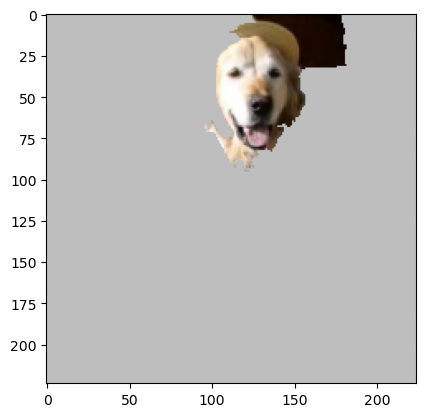

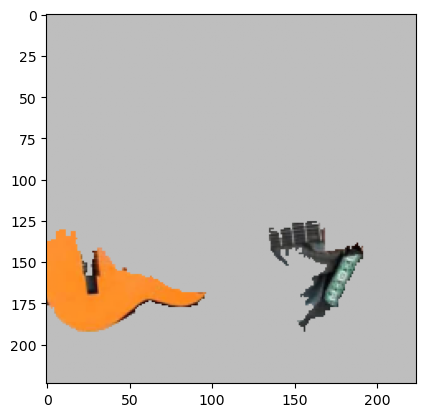

In [6]:
# Attribution by SLIC+shap_sampler+single_color_perturbation+SHAP

# Using TopVisualizer to find the 2 segments with the highest attribution score for labrador and guitar
# The other segments are then removed, showing only the top 2
top2_visualizer = TopVisualizer(k=2)
lab_shap_visual = top2_visualizer(lab_shaps, img, slic_masks)
gui_shap_visual = top2_visualizer(gui_shaps, img, slic_masks)

# Display the 2 segments with the higest attribution scores
plt.figure()
plt.imshow(lab_shap_visual)
plt.figure()
plt.imshow(gui_shap_visual)

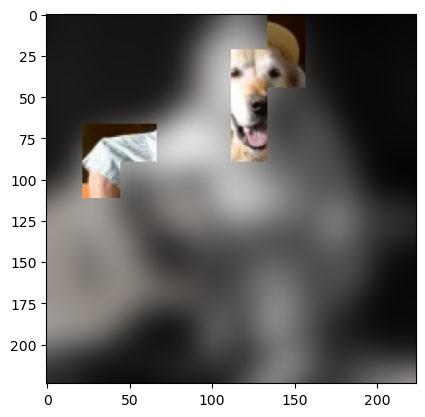

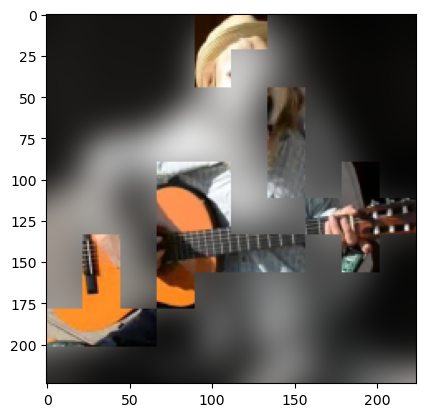

In [7]:
# Attribution by grid+naive_ciu_sampler+blur perturbation+CIU

# Using TopVisualizer to visualize segments such that their combined attribution score is at least 30% of the total
top10percent_visualizer = TopVisualizer(p=0.3, perturber=blur_perturbation)
lab_ciu_visual = top10percent_visualizer(lab_infl, img, grid_masks)
gui_ciu_visual = top10percent_visualizer(gui_infl, img, grid_masks)

# Display the fewest segements that holds at least 30% of the attribution score
plt.figure()
plt.imshow(lab_ciu_visual)
plt.figure()
plt.imshow(gui_ciu_visual)

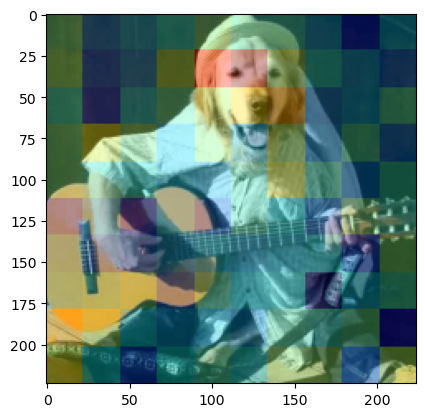

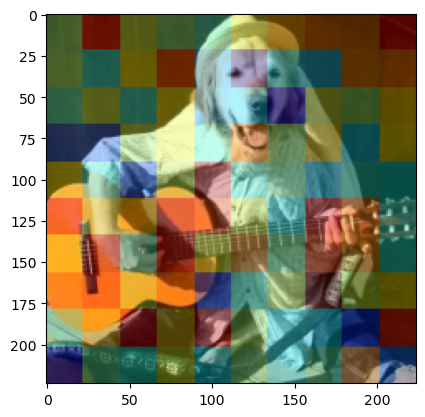

In [8]:
# Attribution by faded grid+random_sampler+noisy perturbation+RISE

# Using HeatmapVisualizer to create a heatmap of the attribution score per segment
# The heatmap is then overlaid the original image to show the strength of attribution
heatmap_visualizer = HeatmapVisualizer(normalize=True, image_weight=0.7, invert_colormap=True)
lab_rise_visual = heatmap_visualizer(lab_rise, img, grid_masks)
gui_rise_visual = heatmap_visualizer(gui_rise, img, grid_masks)

# Display a heatmap of the segment attribution overlaid the original image
plt.figure()
plt.imshow(lab_rise_visual)
plt.figure()
plt.imshow(gui_rise_visual)

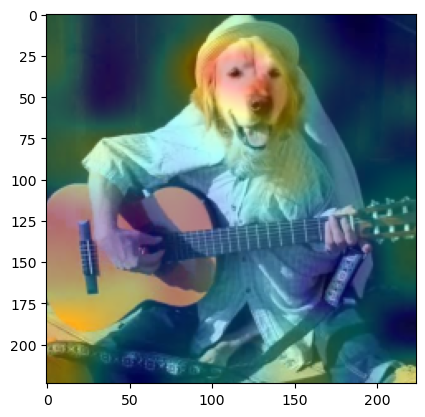

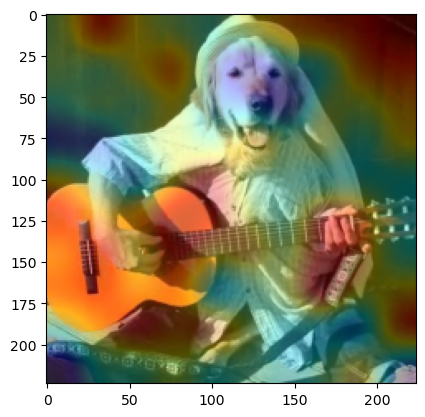

In [9]:
# Pixel attribution by faded grid+random_sampler+noisy perturbation+RISE

# Since RISE can attribute to each pixel, we can use that attribution directly as a heatmap
# If the perturbation masks had not been faded, each pixel would have the same attribution as its segment
lab_rise_pixels_visual = heatmap_visualizer(lab_rise_pixels, img)

# However, we can also achieve almost the exact same results by displaying a heatmap based on the faded masks
# This approach is also applicable to other explainers that doesn't natively handle pixel level attribution
gui_rise_pixels_visual = heatmap_visualizer(gui_rise, img, faded_grid_masks)

# Display a heatmap of pixel attribution overlaid the original image
plt.figure()
plt.imshow(lab_rise_pixels_visual)
plt.figure()
plt.imshow(gui_rise_pixels_visual)

Attribution pipeline:				 Insertion/Deletion AUC:
SLIC+shap_sampler+gray_perturbation+SHAP	 9.8691435
grid+naive_ciu_sampler+blur_perturbation+CIU	 6.5465136
grid+random_sampler+noise_perturbation+RISE	 5.7327094


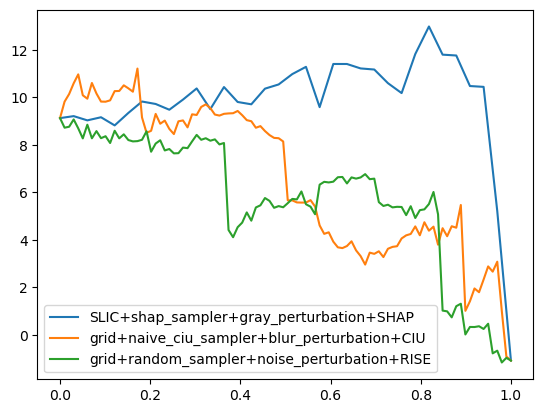

In [10]:
# Calculate the insertion and deletion scores (AUC) of the explainations
# This is done by steadily inserting/deleting more of the image starting with the most
# attributed pixels.
# For insertion a better score is higher since it indicates that the impactful areas were inserted first
# The opposite gies for deletion, with lower scores indicating that the most impactful was deleted first

deletion=False # False to calculate insertion, True to calculate deletion

# Create the samples for calculating insertion/deletion of the labrador
lab_shap_insert_samples = auc_sampler(lab_shaps, mif=deletion)
lab_ciu_insert_samples  = auc_sampler(lab_infl,  mif=deletion)
lab_rise_insert_samples = auc_sampler(lab_rise,  mif=deletion)

# Create the perturbation masks for insertion/deletion
lab_shap_insert_perturbation_masks = perturbation_masks(slic_masks, lab_shap_insert_samples)
lab_ciu_insert_perturbation_masks  = perturbation_masks(grid_masks, lab_ciu_insert_samples)
lab_rise_insert_perturbation_masks = perturbation_masks(grid_masks, lab_rise_insert_samples)

# Perturb the images using solid color to occlude
lab_shap_insert_images, lab_shap_insert_samples = gray_perturbation(img, lab_shap_insert_perturbation_masks, lab_shap_insert_samples)
lab_ciu_insert_images,  lab_ciu_insert_samples  = gray_perturbation(img, lab_ciu_insert_perturbation_masks, lab_ciu_insert_samples)
lab_rise_insert_images, lab_rise_insert_samples = gray_perturbation(img, lab_rise_insert_perturbation_masks, lab_rise_insert_samples)

# Calculate the model output for the insertion images
lab_shap_insert_Y = model(lab_shap_insert_images)
lab_ciu_insert_Y  = model(lab_ciu_insert_images)
lab_rise_insert_Y = model(lab_rise_insert_images)

# Print the AUC scores:
print('Attribution pipeline:\t\t\t\t Insertion/Deletion AUC:')
print('SLIC+shap_sampler+gray_perturbation+SHAP\t', np.mean(lab_shap_insert_Y[:,labrador]))
print('grid+naive_ciu_sampler+blur_perturbation+CIU\t', np.mean(lab_ciu_insert_Y[:,labrador]))
print('grid+random_sampler+noise_perturbation+RISE\t', np.mean(lab_rise_insert_Y[:,labrador]))

# Plot the insertion/deletion curves showing the prediction vs. the fraction of the image inserted/deleted
plt.plot(np.linspace(0,1,len(lab_shap_insert_Y)), lab_shap_insert_Y[:,labrador])
plt.plot(np.linspace(0,1,len(lab_ciu_insert_Y)), lab_ciu_insert_Y[:,labrador])
plt.plot(np.linspace(0,1,len(lab_rise_insert_Y)), lab_rise_insert_Y[:,labrador])
plt.legend(('SLIC+shap_sampler+gray_perturbation+SHAP', 'grid+naive_ciu_sampler+blur_perturbation+CIU', 'grid+random_sampler+noise_perturbation+RISE'))